# Recurrent Neural Network (RNN)

A RNN is actually a ANN that processed data is get pass through the previous non-lienar activation function output.

A very usefull image that shows the structure of the model is this:

<img src = "https://stanford.edu/~shervine/teaching/cs-230/illustrations/description-block-rnn-ltr.png?74e25518f882f8758439bcb3637715e5 raw = True, width = 1500" alt = "RNN Model" width = 1500 >

More info about RNN:

* [CS 230 - RNN](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks#architecture)

* [PyTorch RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

## Import libraries - Prepare the Dataset

In [1]:
!pip install opendatasets

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

#"username":"giorgospapadakis227",
#"key":"0d98fada57d63e3b60481c013c67e993"

import opendatasets as od

od.download("https://www.kaggle.com/competitions/digit-recognizer/data", force = True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: giorgospapadakis227
Your Kaggle Key: ··········


100%|██████████| 15.3M/15.3M [00:00<00:00, 108MB/s] 


Extracting archive ./digit-recognizer/digit-recognizer.zip to ./digit-recognizer


In [29]:
# load data with pands
train = pd.read_csv('/content/digit-recognizer/train.csv', dtype = np.float32)

# split data into features(pixels) and labels
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255# /255 to normalize the pixels

# split the train dataset into 80% train and test 20%
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

# Create Tensors
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# Basic model parameters
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

## Define and construct the RNN

In [30]:
# define the RNN class

class RNNModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(RNNModel, self).__init__()

    # Number of hidden dimensions
    self.hidden_dim = hidden_dim

    # Number of hidden layer
    self.layer_dim = layer_dim

    # RNN from Torch
    self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

    # Readout Layer
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
      # initiate a h_0 hidden state with zeros
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

      # One time step
      out, hn = self.rnn(x, h0)
      out = self.fc(out[:, -1, :])
      return out

In [31]:
# create the model
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Train Model

In [32]:
seq_dim = 28
loss_list = []
iteration_list = []
accuracy_list = []
count = 0

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # Create Variables
    train = Variable(images.view(-1, seq_dim, input_dim))
    labels = Variable(labels)

    # Clear gradients
    optimizer.zero_grad()

    # Forward propagation
    outputs = model(train)

    # Calculate loss
    loss = error(outputs, labels)

    # Calculate gradients
    loss.backward()

    # Update parameters
    optimizer.step()

    count +=1

    if count % 250 == 0:
      correct = 0
      total = 0
      for images, labels in test_loader:
        # Create Variable
        images = Variable(images.view(-1, seq_dim, input_dim))

        # Forward propagation
        outputs = model(images)

        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]

        # Total number of labels
        total += labels.size(0)

        correct += (predicted == labels).sum()

      accuracy = 100*correct/float(total)
      # store loss and iteration
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)
      if count % 500 == 0:
        # Print Loss
        print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.item(), accuracy))

Iteration: 500  Loss: 2.226425886154175  Accuracy: 22.202381134033203 %
Iteration: 1000  Loss: 1.7302916049957275  Accuracy: 37.94047546386719 %
Iteration: 1500  Loss: 0.9145371317863464  Accuracy: 69.22618865966797 %
Iteration: 2000  Loss: 0.4681128263473511  Accuracy: 81.08333587646484 %
Iteration: 2500  Loss: 0.8637742400169373  Accuracy: 77.77381134033203 %
Iteration: 3000  Loss: 0.32462456822395325  Accuracy: 86.02381134033203 %
Iteration: 3500  Loss: 0.6028828620910645  Accuracy: 85.33333587646484 %
Iteration: 4000  Loss: 0.15258483588695526  Accuracy: 90.78571319580078 %
Iteration: 4500  Loss: 0.43861740827560425  Accuracy: 92.04762268066406 %
Iteration: 5000  Loss: 0.11964230239391327  Accuracy: 94.67857360839844 %
Iteration: 5500  Loss: 0.22917968034744263  Accuracy: 95.21428680419922 %
Iteration: 6000  Loss: 0.2698656916618347  Accuracy: 93.76190185546875 %
Iteration: 6500  Loss: 0.07737044990062714  Accuracy: 94.95237731933594 %
Iteration: 7000  Loss: 0.16031748056411743  Ac

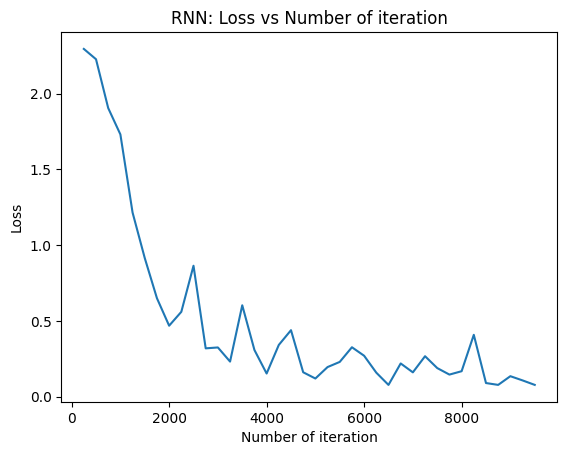

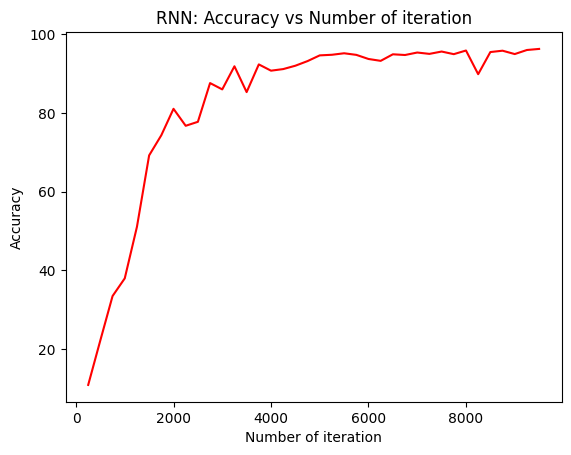

In [33]:
# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()